# Normalizing Flows - Affine Coupling with MLPs

This codebook is a minimal example of the implementation of a normalizing flow composed of affine coupling layers only, which are based on 1D input (hence, they use an MLP).

## Imports

We use numpy to generate artificial data. Torch for our model.

In [11]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal

## Data

We create arbitrary data (noisy sine-waves) of a dimensionality of our preference (1-dimensional).

In [12]:
class TensorDataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx]

In [13]:
# Define data parameters (dimensionality and number of samples)
in_dimension = 300
n_samples = 100
batch_size = 8

# Create an artificial dataset
dataset = TensorDataset(
    torch.tensor([
        np.sin(np.linspace(0, 2 * np.pi, in_dimension) + np.random.rand(in_dimension))
        for _ in range(n_samples)
    ]).float() 
)
loader = DataLoader(dataset, batch_size=batch_size)

### Plotting the data

Since we use high dimensional data (where values on each dimension oscillate like in a sine-wave), we can plot the value on each dimension for all samples.

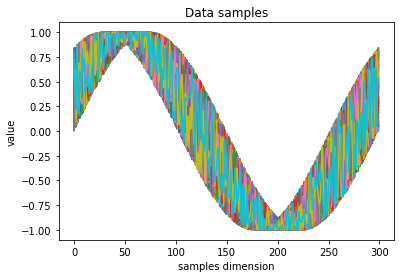

In [14]:
x_axis = np.arange(in_dimension)
for sample in dataset:
    plt.plot(x_axis, sample)
plt.xlabel("samples dimension")
plt.ylabel("value")
plt.title("Data samples")
plt.show()

## Model

We implement the AffineCoupling layer first. The FlowModel is just going to be a sequential execution of such layers.

In [15]:
class AffineCoupling(nn.Module):
    def __init__(self, in_dim, on_first=True, sigmoid=False):
        super(AffineCoupling, self).__init__()
        assert in_dim % 2 == 0, f"Input dimension for {self.__class__} is not even: found {in_dim}"

        # Any non-linear function can be used to obtain scale and translation.
        # The same network outputs both scale and translation parameters.
        self.net = nn.Sequential(
            nn.Linear(in_dim // 2, in_dim * 2),
            nn.ReLU(),
            nn.Linear(in_dim * 2, in_dim)
        )

        # Tells on which half should the model operate the affine coupling
        self.on_first = on_first
        self.sigmoid = sigmoid

    def forward(self, x):
        # Divide the input into two equally-sized chunks
        x1, x2 = x.chunk(2, 1)

        # Swap halves if option is selected
        if not self.on_first:
            x1, x2 = x2, x1

        # Compute output and log of determinant
        s, t = self.net(x1).chunk(2, 1)

        if self.sigmoid:
            # Trick: use sigmoid to stabilize training
            s = torch.sigmoid(s + 2)
            out = torch.cat((x1, x2 * s + t), dim=1)
            log_det = torch.sum(torch.log(s), dim=1)
            return out, log_det

        out = torch.cat((x1, x2 * torch.exp(s) + t), dim=1)
        log_det = torch.sum(s, dim=[1])
        return out, log_det

    def backward(self, out):
        # Split output into the two halves
        x1, x2 = out.chunk(2, 1)

        # Undo the affine transformation
        s, t = self.net(x1).chunk(2, 1)

        if self.sigmoid:
            # Sigmoid trick
            s = torch.sigmoid(s + 2)

        x2 = (x2 - t) / (torch.exp(s) if not self.sigmoid else s)

        # Swap places if needed
        if not self.on_first:
            x1, x2 = x2, x1

        return torch.cat((x1, x2), dim=1)

In [16]:
class FlowModel(nn.Module):
    def __init__(self, in_dim, n_steps, sigmoid=False):
        super(FlowModel, self).__init__()
        self.in_dim = in_dim
        self.n_steps = n_steps
        self.sigmoid = sigmoid
        self.layers = nn.ModuleList([
            AffineCoupling(in_dim, i % 2 == 0, sigmoid=self.sigmoid)
            for i in range(n_steps)
        ])

    def forward(self, x):
        # Running input through all affine coupling layers
        out, total_log_det = x, 0.0
        for layer in self.layers:
            out, log_det = layer(out)
            total_log_det += log_det
        return out, total_log_det

    def backward(self, out):
        # Running backward through all layers starting from the last
        x = out
        n = len(self.layers)
        for i in range(len(self.layers)):
            x = self.layers[n - 1 - i].backward(x)
        return x

# Main program

We train two models on our arbitrary data. The models differ in that one uses the sigmoid activation trick, and the second doesn't. We compare their training curves. 

We then just keep the model that uses the sigmoid trick and check that samples are mapped to a normal distribution. Also, we check that the function is invertible.

**Optional: ** Try to keep the model that doesn't use the sigmoid trick for the next cells, and check the likelihood of the latent distribution.



Model with sigmoid trick
	Epoch 1 loss: 535.05
	Epoch 20 loss: 1.79
	Epoch 40 loss: 1.48
	Epoch 60 loss: 1.17
	Epoch 80 loss: 2.10
	Epoch 100 loss: 0.95
	Epoch 120 loss: 0.92
	Epoch 140 loss: 0.90
	Epoch 160 loss: 0.64
	Epoch 180 loss: 0.58
	Epoch 200 loss: 0.61


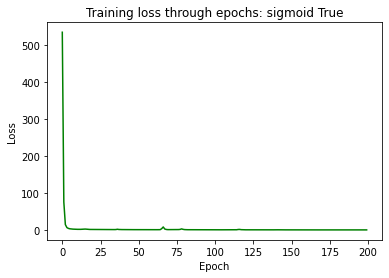

In [17]:
# Parameters
n_steps = 4
n_epochs = 200
print_freq = n_epochs // 10
lr = 0.01

for sigmoid in [True]:
    print(f"\n\nModel {'with' if sigmoid else 'without'} sigmoid trick")

    # Model and optimizer
    model = FlowModel(in_dimension, n_steps, sigmoid=sigmoid)
    optim = Adam(model.parameters(), lr=lr)

    # Plotting variable
    losses = []

    # Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for x in loader:
            out, log_det = model(x)

            # The loss is the log likelihood for a normal distribution minus the log_det
            pz = torch.sum(out**2 / in_dimension**0.5, dim=1)
            loss = torch.mean(pz - log_det)
            epoch_loss += loss.item() / len(x)

            optim.zero_grad()
            loss.backward()
            optim.step()

        losses.append(epoch_loss)
        if (epoch + 1) % print_freq == 0 or epoch == 0:
            print(
                f"\tEpoch {epoch + 1} loss: {epoch_loss:.2f}"
            )

    start = 0

    # Plotting training curve
    plt.plot(np.arange(len(losses[start:])), losses[start:], "g-", label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training loss through epochs: sigmoid {sigmoid}")
    plt.show()

## Testing invertibility

We test the invertibility by checking the MSE between the input and the re-construction.

In [18]:
with torch.no_grad():
    x = dataset.tensor
    out, _ = model(x)
    reconstructed = model.backward(out)

mse = torch.mean((x - reconstructed) ** 2)
print(f"Mean squared error between original and reconstruction: {mse.item():.9f}")

Mean squared error between original and reconstruction: 0.000000000


## Tesing mapping to a normal

We test that the input was mapped to a normal distribution with mean 0 and std 1 by checking the mean probability.

In [19]:
normal = Normal(0, 1)

mean_prob = torch.mean(torch.exp(normal.log_prob(out))).item()
p_0 = torch.exp(normal.log_prob(torch.tensor([0]))).item()

print(f"Mean probability Pz is: {mean_prob:.3f}")
print(f"Probability for x=0 (normal distribution): {p_0:.3f}")

Mean probability Pz is: 0.395
Probability for x=0 (normal distribution): 0.399


## Plotting latent prior

We use the same plotting strategy as before. We compare the samples obtained from a normal gaussian distribution with the samples that are output by our Flow model.

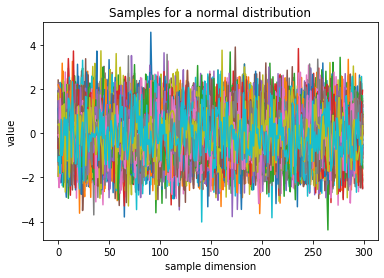

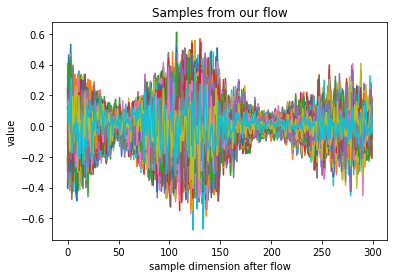

In [20]:
# Plotting some samples drawn from the normal distribution
normal_samples = normal.sample((n_samples, in_dimension))
for sample in normal_samples.numpy():
    plt.plot(x_axis, sample)
plt.xlabel("sample dimension")
plt.ylabel("value")
plt.title("Samples for a normal distribution")
plt.show()

# Plotting our samples
for sample in out.numpy():
    plt.plot(x_axis, sample)
plt.xlabel("sample dimension after flow")
plt.ylabel("value")
plt.title("Samples from our flow")
plt.show()

# Conclusion

With this notebook, we learned how to implement (from scratch) a normalizing flow composed of affine coupling layers only. The flow implements an invertible function which can map an input to a desired prior distribution. In this example, such distribution is a gaussian with mean 0 and standard deviation 1.



<center><h2>Credits</h2></center>

**Brian Pulfer** ([Website](https://www.brianpulfer.ch), [Twitter](https://twitter.com/PulferBrian21), [GitHub](https://github.com/BrianPulfer), [LinekdIn](https://www.linkedin.com/in/BrianPulfer/))<br/>
University of Geneva <br/>
26.04.2022